In [55]:
pip install keras==2.12.0

In [56]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from imblearn.over_sampling import SMOTE
import tensorflow as tf
import logging


In [57]:
df= pd.read_csv("/content/happydata.csv")


In [58]:
df

,infoavail,housecost,schoolquality,policetrust,streetquality,ëvents,happy
0,3,3,3,4,2,4,0
1,3,2,3,5,4,3,0
2,5,3,3,3,3,5,1
3,5,4,3,3,3,5,0
4,5,4,3,3,3,5,0
...,...,...,...,...,...,...,...
138,5,3,3,1,3,5,0
139,5,2,3,4,2,5,1
140,5,3,3,4,4,5,1
141,4,3,3,4,4,5,0


<font color='green'>### Check Dataset has duplicate values

In [59]:
duplicates = df[df.duplicated(keep='first')]

In [60]:
duplicates

,infoavail,housecost,schoolquality,policetrust,streetquality,ëvents,happy
4,5,4,3,3,3,5,0
21,4,2,3,3,4,4,1
23,4,3,5,5,5,4,0
29,3,3,1,3,3,4,1
35,3,2,4,4,4,5,1
39,5,3,4,3,4,5,1
53,5,1,3,3,4,4,1
54,5,1,3,3,4,4,1
56,5,2,4,3,4,5,1
58,4,3,2,4,3,4,1


- Drop duplicates value

In [61]:
df_no_duplicates = df.drop_duplicates()

In [62]:
duplicates = df_no_duplicates[df_no_duplicates.duplicated(keep='first')]

In [63]:
duplicates

,infoavail,housecost,schoolquality,policetrust,streetquality,ëvents,happy


In [64]:
df_no_duplicates.shape

(125, 7)

In [65]:
df_no_duplicates.head(10)

,infoavail,housecost,schoolquality,policetrust,streetquality,ëvents,happy
0,3,3,3,4,2,4,0
1,3,2,3,5,4,3,0
2,5,3,3,3,3,5,1
3,5,4,3,3,3,5,0
5,5,5,3,5,5,5,1
6,3,1,2,2,1,3,0
7,5,4,4,4,4,5,1
8,4,1,4,4,4,4,0
9,4,4,4,2,5,5,0
10,3,2,3,3,2,3,0


### Shuffled the values

In [66]:
df_shuffled = df_no_duplicates.sample(frac=1).reset_index(drop=True)


In [67]:
df_shuffled.head(10)

,infoavail,housecost,schoolquality,policetrust,streetquality,ëvents,happy
0,5,2,3,3,4,5,0
1,4,3,3,4,4,4,1
2,5,3,4,4,4,5,1
3,4,2,4,3,2,4,1
4,5,3,4,4,4,4,1
5,5,3,3,3,2,5,0
6,5,2,3,5,5,5,1
7,4,2,4,5,4,3,0
8,3,2,3,3,5,4,0
9,4,5,5,5,1,3,0


In [68]:
# Calculate correlation coefficients
correlation_matrix = df.corr()
correlation_with_target = correlation_matrix['happy'].sort_values(ascending=False)

# Print correlation coefficients
print(correlation_with_target)

happy            1.000000
infoavail        0.312740
ëvents           0.220729
streetquality    0.206685
schoolquality    0.163639
policetrust      0.113356
housecost        0.019368
Name: happy, dtype: float64


In [69]:
# Split features and target variable
X_with_house = df_shuffled.drop(columns=['happy'])
y = df_shuffled['happy']

In [70]:
# Drop the "housecost" feature from the dataset as we can see : 0.019
X = X_with_house.drop(columns=['housecost'])

In [71]:
# Apply data balancing techniques
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Preprocessing steps
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)  # Apply scaling to balanced data

# Split the balanced data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.3, random_state=42)

# Split the Train data into train, validation sets
X_train_final, X_val, y_train_final, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)


In [72]:

from keras.callbacks import ModelCheckpoint, EarlyStopping

class ANNModel:
    def __init__(self, input_shape, optimizer, checkpoint, early_stopping):       # Constructor
        self.input_shape = input_shape
        self.optimizer = optimizer
        self.checkpoint= checkpoint
        self.early_stopping= early_stopping
        self.model = self._build_model()

    def _build_model(self):
        model = Sequential()
        model.add(Dense(64, input_dim=self.input_shape, activation='relu'))  # 1st hidden layer with 64 nodes
        model.add(Dense(32, activation='relu'))  # 2nd hidden layer with 32 nodes
        model.add(Dropout(0.2))  # Adding dropout with 20%
        model.add(Dense(16, activation='relu'))  # 3rd hidden layer with 16 nodes
        model.add(Dense(8, activation='relu'))   # Additional hidden layer with 8 nodes
        model.add(Dense(1, activation='sigmoid'))  # Output layer with 1 node and sigmoid activation for binary classification
        return model

    def compile_model(self):
        self.model.compile(optimizer=self.optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    def train_model(self, X_train, y_train, epochs=10, batch_size=32, validation_data=None):
        history = self.model.fit(X_train, y_train,
                                 epochs=epochs,
                                 batch_size=batch_size,
                                 validation_data=validation_data,
                                 callbacks=[checkpoint, early_stopping])

        return self.model, history


input_shape = 5  # Assuming 13 features

opt = keras.optimizers.SGD(learning_rate=0.001, momentum=0.01, nesterov=False)

early_stopping= keras.callbacks.EarlyStopping(
    monitor="val_loss",                               # watch validation loss
    min_delta=0,
    patience=5,                                       # patience:  number of epochs with no improvement after which training will be stopped
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0)

checkpoint= keras.callbacks.ModelCheckpoint(
    'ANNmodel_weights.h5',                            # a file will be saved in h5 format
    monitor="val_loss",
    verbose=0,
    save_best_only=True,                              # will save the model weights only when the val_loss  has improved from the previous best value
    save_weights_only=False,                           # only the weights of the model will be saved, rather than saving the entire model
    mode="auto",
    save_freq="epoch",
    initial_value_threshold=None,
)


# Create ANN model object
ann_model = ANNModel(input_shape= input_shape, optimizer= opt,checkpoint= checkpoint, early_stopping=early_stopping)

# Compile the model
ann_model.compile_model()

# Train the model
trained_model, history = ann_model.train_model(X_train, y_train,
                                               epochs=250, batch_size=8, validation_data=(X_test, y_test))

Epoch 1/250
11/11 [==============================] - 1s 22ms/step - loss: 0.6911 - accuracy: 0.4886 - val_loss: 0.6917 - val_accuracy: 0.5263
Epoch 2/250
11/11 [==============================] - 0s 7ms/step - loss: 0.6963 - accuracy: 0.4886 - val_loss: 0.6914 - val_accuracy: 0.5263
Epoch 3/250
11/11 [==============================] - 0s 8ms/step - loss: 0.6950 - accuracy: 0.5000 - val_loss: 0.6911 - val_accuracy: 0.5263
Epoch 4/250
11/11 [==============================] - 0s 8ms/step - loss: 0.6947 - accuracy: 0.4886 - val_loss: 0.6908 - val_accuracy: 0.5263
Epoch 5/250
11/11 [==============================] - 0s 8ms/step - loss: 0.6936 - accuracy: 0.5000 - val_loss: 0.6905 - val_accuracy: 0.5263
Epoch 6/250
11/11 [==============================] - 0s 8ms/step - loss: 0.6988 - accuracy: 0.4886 - val_loss: 0.6901 - val_accuracy: 0.5263
Epoch 7/250
11/11 [==============================] - 0s 8ms/step - loss: 0.6863 - accuracy: 0.5000 - val_loss: 0.6899 - val_accuracy: 0.5263
Epoch 8/250


In [73]:
from sklearn.metrics import f1_score

y_pred = trained_model.predict(X_test)

# Convert predicted probabilities to binary predictions (0 or 1)
y_pred_binary = (y_pred > 0.5).astype(int)

# Calculate F1 score
f1 = f1_score(y_test, y_pred_binary)
print("F1 Score:", f1)

2/2 [==============================] - 0s 5ms/step
F1 Score: 0.6666666666666666


In [74]:
# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_binary)

In [75]:
cm

array([[14,  6],
       [ 6, 12]])

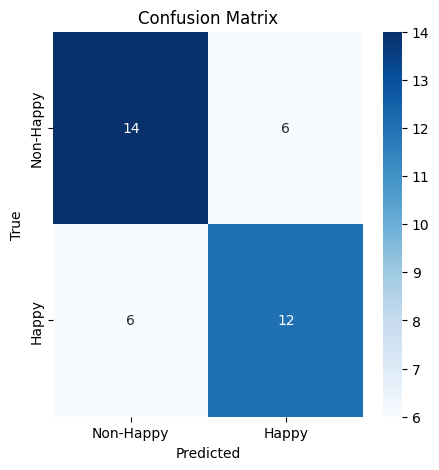

In [78]:
# Plot confusion matrix as heatmap
plt.figure(figsize=(5,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Happy', 'Happy'], yticklabels=['Non-Happy', 'Happy'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()